In [1]:
import pandas as pd
import numpy as np
import tweepy
import requests
import re
from functools import reduce
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO

## Gathering data

<h4><font color='blue'><left> The WeRateDogs Twitter archive</left></h4>

This file are downloaded manually and uploaded to the jupyter notebook 

In [2]:
df_arch=pd.read_csv('twitter-archive-enhanced.csv')

In [3]:
df_arch.head(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None


<h4><font color='blue'><left> Tweet retweet and favorite count</left></h4>

Using Tweepy library we will query the Twitter API converting the result to dataframe then store it as text file

In [2]:
#Authentification to twetter API 
consumer_key=''
consumer_secret=''
access_token=''
access_token_secret=''
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)



In [11]:
#Extract the retwette count and the favorites count froms tweets (status) using tweet_id stored in twitter-archive-enhanced.csv
status_df=[]
errors= []
tweet_ids=list(df_arch.tweet_id)
for ids in tweet_ids:
    try:
        status=api.get_status(ids)
        retw_count=status.retweet_count
        fav_count= status.favorite_count
        status_df.append({'status_id':tweet_id, 'retweet_count': int(retw_count),
                         'favorite_count': int(fav_count)})
    except Exception as error:
        errors.append({'status_id': tweet_id, 'error': error})

        


In [15]:
len(errors)

1479

1479 errors are generated, this number mean that we failed to get retweet and favotites count for 1479 status, this is because we didn't give a wait time to tweeter API for rate limits replenishment, we will add `wait_on_rate_limit` argument to decrease this error number

In [8]:
status_df2=[]
errors2= []
tweet_ids=list(df_arch.tweet_id)
for ids in tweet_ids:
    try:
        status=api.get_status(ids, wait_on_rate_limit=True)
        retw_count=status.retweet_count
        fav_count= status.favorite_count
        status_df2.append({'status_id':ids, 'retweet_count': int(retw_count),
                         'favorite_count': int(fav_count)})
    except Exception as error:
        errors2.append({'status_id': ids, 'error': error})

In [11]:
# calculate errors number
len(errors2)

25

25 errors after adding `wait_on_rate_limit=True` argument to `api.get_status` statement

In [12]:

errors2

[{'status_id': 888202515573088257,
  'error': tweepy.error.TweepError([{'code': 144,
                            'message': 'No status found with that ID.'}])},
 {'status_id': 873697596434513921,
  'error': tweepy.error.TweepError([{'code': 144,
                            'message': 'No status found with that ID.'}])},
 {'status_id': 872668790621863937,
  'error': tweepy.error.TweepError([{'code': 144,
                            'message': 'No status found with that ID.'}])},
 {'status_id': 872261713294495745,
  'error': tweepy.error.TweepError([{'code': 144,
                            'message': 'No status found with that ID.'}])},
 {'status_id': 869988702071779329,
  'error': tweepy.error.TweepError([{'code': 144,
                            'message': 'No status found with that ID.'}])},
 {'status_id': 866816280283807744,
  'error': tweepy.error.TweepError([{'code': 144,
                            'message': 'No status found with that ID.'}])},
 {'status_id': 861769973181624320,

In [25]:
#transform the list of dictionaries to a dataframe
df_columns=['status_id', 'retweet_count', 'favorite_count']
df=pd.DataFrame(status_df2, columns= df_columns)

In [26]:
#save dataframe as text file
df.to_csv('tweet_json.txt', encoding='utf-8', index=False)

In [3]:
#read the tweet_json.txt as dataframe
df_tweet=pd.read_csv('tweet_json.txt')

In [49]:
df_tweet.head()

,status_id,retweet_count,favorite_count
0,892420643555336193,7329,34932
1,892177421306343426,5472,30249
2,891815181378084864,3620,22764
3,891689557279858688,7521,38197
4,891327558926688256,8088,36472


<h4><font color='blue'><left> Tweet image predictions</left></h4>

`Tweet image predictions.tsv` is hosted on Udacity's servers, we will download and store this  file programmatically using `Requests` library, then read it as data frame

In [16]:
#download programmatically the 'image_prediction.tsv'
URL='https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response=requests.get(URL)
with open('image_prediction.tsv', mode= 'wb') as file:
    file.write(response.content)

    

In [4]:
df_img=pd.read_csv('image_prediction.tsv', sep='\t')
df_img.sample(3)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
682,683834909291606017,https://pbs.twimg.com/ext_tw_video_thumb/68383...,1,Maltese_dog,0.738449,True,toy_poodle,0.102992,True,Samoyed,0.023247,True
1292,751583847268179968,https://pbs.twimg.com/media/Cm4phTpWcAAgLsr.jpg,1,dalmatian,0.868304,True,studio_couch,0.059623,False,snow_leopard,0.013876,False
928,702684942141153280,https://pbs.twimg.com/media/CcBwOn0XEAA7bNQ.jpg,1,golden_retriever,0.514085,True,Chesapeake_Bay_retriever,0.173224,True,Brittany_spaniel,0.118384,True


## Assessing data

<h4><font color='blue'><left> The WeRateDogs Twitter archive</left></h4>

In [11]:
df_arch.head(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [8]:
df_arch.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [10]:
df_arch.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [12]:
df_arch['name'].value_counts()

None            745
a                55
Charlie          12
Cooper           11
Oliver           11
Lucy             11
Tucker           10
Penny            10
Lola             10
Winston           9
Bo                9
Sadie             8
the               8
Toby              7
Bailey            7
Buddy             7
an                7
Daisy             7
Leo               6
Scout             6
Oscar             6
Dave              6
Jax               6
Koda              6
Jack              6
Rusty             6
Bella             6
Milo              6
Stanley           6
Sunny             5
               ... 
Timmy             1
Eriq              1
Mike              1
Hamrick           1
Alexanderson      1
Sundance          1
Acro              1
Spencer           1
Obie              1
Snoopy            1
Nico              1
Kody              1
Laela             1
Theo              1
Smiley            1
Rorie             1
Stormy            1
Chloe             1
Jessifer          1


In [39]:
mask = (df_arch['name'].str.len()<=2)
df_arch.loc[mask]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
56,881536004380872706,NaN,NaN,2017-07-02 15:32:16 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a pupper approaching maximum borkdrive...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/881536004...,14,10,a,None,None,pupper,None
393,825876512159186944,NaN,NaN,2017-01-30 01:21:19 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Mo. No one will push him around in the...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/825876512...,11,10,Mo,None,None,None,None
446,819015337530290176,NaN,NaN,2017-01-11 02:57:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Bo. He was a very good ...,8.190048e+17,4.196984e+09,2017-01-11 02:15:36 +0000,https://twitter.com/dog_rates/status/819004803...,14,10,Bo,doggo,None,None,None
449,819004803107983360,NaN,NaN,2017-01-11 02:15:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bo. He was a very good First Doggo. 14...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/819004803...,14,10,Bo,doggo,None,None,None
553,804026241225523202,NaN,NaN,2016-11-30 18:16:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bo. He's going to make me cry. 13/10 p...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/804026241...,13,10,Bo,None,None,None,None
583,800188575492947969,NaN,NaN,2016-11-20 04:06:37 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Bo. He's a Benedoop Cum...,6.816941e+17,4.196984e+09,2015-12-29 04:31:49 +0000,https://twitter.com/dog_rates/status/681694085...,11,10,Bo,None,None,pupper,None
649,792913359805018113,NaN,NaN,2016-10-31 02:17:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a perfect example of someone who has t...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/792913359...,13,10,a,None,None,None,None
679,789137962068021249,NaN,NaN,2016-10-20 16:15:26 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bo. He's a West Congolese Bugaboop Snu...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/789137962...,12,10,Bo,None,None,None,None
686,788070120937619456,NaN,NaN,2016-10-17 17:32:13 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Bo and Ty. Bo eats pape...,7.610045e+17,4.196984e+09,2016-08-04 01:03:17 +0000,https://twitter.com/dog_rates/status/761004547...,11,10,Bo,None,None,None,None
759,778396591732486144,NaN,NaN,2016-09-21 00:53:04 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is an East African Chalupa...,7.030419e+17,4.196984e+09,2016-02-26 02:20:37 +0000,https://twitter.com/dog_rates/status/703041949...,10,10,an,None,None,None,None


In [19]:
df_arch.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [29]:
df_arch[df_arch.duplicated(['tweet_id'], keep=False)]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


- Data in source column are not clear  
- Columns `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`   and `retweeted_status_user_id` are floats insted of int
- Columns `doggo`, `floofer`, `pupper` and `puppo` represente the same meaning (dog stage)  
- `timestamp` is object insted of datetime  
- missing data in `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`   and `retweeted_status_user_id` columns
- invalid rating in `rating_numerator` and `rating_denominator` columns
- 'None' used to indicate a missing value instead of 'NaN' in `name` column
- invalid 'names' in `name` columns e.g. (55 names = 'a')
- `source` column are 'object' instead of 'category' data type (there is only 3 repeated sources) 






<h4><font color='blue'><left> Tweet image predictions</left></h4>

In [16]:
df_img.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [18]:
df_img.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [52]:
df_img[df_img.duplicated(['tweet_id'], keep=False)]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


In [32]:
df_img.p1.value_counts()

golden_retriever             150
Labrador_retriever           100
Pembroke                      89
Chihuahua                     83
pug                           57
chow                          44
Samoyed                       43
toy_poodle                    39
Pomeranian                    38
malamute                      30
cocker_spaniel                30
French_bulldog                26
Chesapeake_Bay_retriever      23
miniature_pinscher            23
seat_belt                     22
Staffordshire_bullterrier     20
Siberian_husky                20
German_shepherd               20
Cardigan                      19
web_site                      19
teddy                         18
Shetland_sheepdog             18
beagle                        18
Eskimo_dog                    18
Maltese_dog                   18
Shih-Tzu                      17
Rottweiler                    17
Lakeland_terrier              17
Italian_greyhound             16
kuvasz                        16
          

In [33]:
df_img.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [47]:
df_img[df_img['p1_dog']==False].head(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
17,666104133288665088,https://pbs.twimg.com/media/CT56LSZWoAAlJj2.jpg,1,hen,0.965932,False,cock,0.033919,False,partridge,0.000052,False
18,666268910803644416,https://pbs.twimg.com/media/CT8QCd1WEAADXws.jpg,1,desktop_computer,0.086502,False,desk,0.085547,False,bookcase,0.079480,False
21,666293911632134144,https://pbs.twimg.com/media/CT8mx7KW4AEQu8N.jpg,1,three-toed_sloth,0.914671,False,otter,0.015250,False,great_grey_owl,0.013207,False


In [60]:
df_img['tweet_id'].nunique()

2075

In [59]:
df_img['jpg_url'].nunique()

2009

- `p1_dog`, `p2_dog` and `p3_dog` columns must be 'Category' insted of 'object' data type  
- All columns from `p1_dog` to `p3_conf` are used to predict the dog breeds instead of one column
- somme of images are duplicated in `jpg_url` column

<h4><font color='blue'><left> Tweet retweet and favorite count</left></h4>

In [51]:
df_tweet.sample(5)

,status_id,retweet_count,favorite_count
1529,688908934925697024,730,2024
2238,667544320556335104,482,787
338,831315979191906304,1075,6356
1472,692530551048294401,392,1764
114,869772420881756160,9025,39136


In [52]:
df_tweet.describe()

,status_id,retweet_count,favorite_count
count,2.331000e+03,2331.000000,2331.000000
mean,7.419079e+17,2580.561133,7294.184470
std,6.823170e+16,4364.537683,11330.512427
min,6.660209e+17,1.000000,0.000000
25%,6.782670e+17,524.000000,1262.000000
50%,7.182469e+17,1204.000000,3160.000000
75%,7.986692e+17,2985.500000,8917.000000
max,8.924206e+17,74043.000000,150091.000000


In [53]:
df_tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 3 columns):
status_id         2331 non-null int64
retweet_count     2331 non-null int64
favorite_count    2331 non-null int64
dtypes: int64(3)
memory usage: 54.7 KB



<h1><font color='red'><center> issues sammury</center></h1> 
    
    

    
| <h3><center>Dateframe</center></h3> | <h3><center>Issue</center></h3> | <h3><center>issue type </center></h3> |
|:-|:---|--|
|<div style="text-align: center">df_arch </div> | <div style="text-align: left"> Columns `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`   and `retweeted_status_user_id` are floats insted of int</div> | Quality |
|<div style="text-align: center">df_arch</div>| <div style="text-align: left">Data in `source` column are not clear and unreadable   | Quality |
|<div style="text-align: center">df_arch</div>| <div style="text-align: left">`timestamp` is object insted of datetime </div>| Quality |
|<div style="text-align: center">df_arch</div>| <div style="text-align: left">missing data in `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`   and `retweeted_status_user_id` columns </div>| Quality |
|<div style="text-align: center">df_arch</div>| <div style="text-align: left">invalid rating in `rating_numerator` and `rating_denominator` columns </div>| Quality |
|<div style="text-align: center">df_arch</div>| <div style="text-align: left">'None' used to indicate a missing value instead of 'NaN' in `name` column </div>| Quality |
|<div style="text-align: center">df_arch</div>| <div style="text-align: left">invalid 'names' in `name` columns e.g. (55 names = 'a')</div>| Quality |
|<div style="text-align: center">df_arch</div>| <div style="text-align: left">`source` column are 'object' instead of 'category' data type (there is only 3 repeated sources)</div>| Quality |
|<div style="text-align: center">df_img</div>| <div style="text-align: left">- `p1`, `p2` and `p3` columns must be 'Category' insted of 'object' data type </div>| Quality |
|<div style="text-align: center">df_img</div>| <div style="text-align: left">- somme of images are duplicated in `jpg_url` column </div>| Quality |
|<div style="text-align: center">df_arch</div>| <div style="text-align: left">- Columns `doggo`, `floofer`, `pupper` and `puppo` represente the dog stage it must be grouped in one column (dog_stage)</div>| Tideness|
|<div style="text-align: center">df_img</div>| <div style="text-align: left">- All columns from `p1_dog` to `p3_conf` are used to predict the dog breeds instead of one column </div>| Tideness |
|<div style="text-align: center">tweet_df</div>| <div style="text-align: left">- Rename `status_id` column to `tweet_id` to be able to join dataframes </div>| Tideness |
|<div style="text-align: center">All</div>| <div style="text-align: left">- All tables must be merged to one table </div>| Tideness |


## Cleaning data

In [61]:
df_img=pd.read_csv('image_prediction.tsv', sep='\t')
df_tweet=pd.read_csv('tweet_json.txt')
df_arch=pd.read_csv('twitter-archive-enhanced.csv')

In [62]:
#Copying all dataframes to save the originals
df_arch_clean=df_arch.copy()
df_img_clean=df_img.copy()
df_tweet_clean=df_tweet.copy()

<h4><font color='blue'><left> Define</left></h4>

Group columns `doggo`, `floofer`, `pupper` and `puppo` to one column called `stage`, then drop variable column and duplicates generated from this process.

<h4><font color='blue'><left> Code</left></h4>

In [63]:
#Get the identifier variables columns names
ident_columns=list(df_arch_clean.loc[:,'tweet_id':'name'].columns)
#Get the Columns to unpivot
val_columns= list(df_arch_clean.loc[:,'doggo':'puppo'].columns)
#melt dog stages 
df_arch_clean=pd.melt(df_arch_clean, id_vars=ident_columns, value_vars=val_columns, value_name='stage')
#Drop variable column
df_arch_clean.drop(columns=['variable'], inplace=True)
#Drop generated duplicates
df_arch_clean=df_arch_clean.drop_duplicates()

In [64]:
df_arch_clean.stage.value_counts()

None       2356
pupper      257
doggo        97
puppo        30
floofer      10
Name: stage, dtype: int64

In [65]:
df_arch_clean.shape

(2750, 14)

In [66]:
#Show the remaining duplicates in tweet_id
df_arch_clean[df_arch_clean.duplicated(subset='tweet_id', keep=False)].sort_values('tweet_id')


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,stage
2017,672160042234327040,NaN,NaN,2015-12-02 21:06:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bubba. He's a Titted Peebles Aorta. Ev...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/672160042...,8,10,Bubba,None
6729,672160042234327040,NaN,NaN,2015-12-02 21:06:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bubba. He's a Titted Peebles Aorta. Ev...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/672160042...,8,10,Bubba,pupper
2015,672205392827572224,NaN,NaN,2015-12-03 00:07:09 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Opal. He's a Royal John Coctostan. Rea...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/672205392...,9,10,Opal,None
6727,672205392827572224,NaN,NaN,2015-12-03 00:07:09 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Opal. He's a Royal John Coctostan. Rea...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/672205392...,9,10,Opal,pupper
2009,672254177670729728,NaN,NaN,2015-12-03 03:21:00 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Rolf. He's having the time of his life...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/672254177...,11,10,Rolf,None
6721,672254177670729728,NaN,NaN,2015-12-03 03:21:00 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Rolf. He's having the time of his life...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/672254177...,11,10,Rolf,pupper
6714,672481316919734272,NaN,NaN,2015-12-03 18:23:34 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Jazz. She should be on the cover ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/672481316...,12,10,Jazz,pupper
2002,672481316919734272,NaN,NaN,2015-12-03 18:23:34 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Jazz. She should be on the cover ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/672481316...,12,10,Jazz,None
6707,672594978741354496,NaN,NaN,2015-12-04 01:55:13 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Scott. Just trying to catch his train to ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/672594978...,9,10,Scott,pupper
1995,672594978741354496,NaN,NaN,2015-12-04 01:55:13 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Scott. Just trying to catch his train to ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/672594978...,9,10,Scott,None


Assessing visually duplicates in tweet_id we notice that there is a 'None' stages generated from the previews melting process, we still have to drop this rows from duplicated rows

In [67]:
#Get the duplicated rows 
df_dup=df_arch_clean[df_arch_clean.duplicated(subset='tweet_id', keep=False)]
#Get duplicated rows where stages is 'None' 
dup_index=df_dup[df_dup['stage']=='None'].index
#Drop duplicated rows and keep correct stage value
df_arch_clean.drop(dup_index, inplace=True)

In [68]:
df_arch_clean[df_arch_clean.duplicated(subset='tweet_id', keep=False)].shape

(28, 14)

28 duplicated tweet_id still present in the dataframe

In [69]:
#show the 28 remaining duplicated tweet_id 
df_dup2=df_arch_clean[df_arch_clean.duplicated(subset='tweet_id', keep=False)][['tweet_id', 'stage']]
df_dup2.sort_values('tweet_id')

,tweet_id,stage
1113,733109485275860992,doggo
5825,733109485275860992,pupper
1063,741067306818797568,doggo
5775,741067306818797568,pupper
5668,751583847268179968,pupper
956,751583847268179968,doggo
889,759793422261743616,doggo
5601,759793422261743616,pupper
822,770093767776997377,doggo
5534,770093767776997377,pupper


Assessing visually the rest of duplicated columns we can see that it is probably an error the stage 'doggo' is present in front of another type of stages for every same tweet_id, so better to keep the other stages and drop rows with 'doggo'.

In [70]:
#Get the duplicated rows with 'doggo' as stage
dup_index2=df_dup2[df_dup2['stage']=='doggo'].index
#Drop duplicated rows and keep only other stages
df_arch_clean.drop(dup_index2, inplace=True)

<h4><font color='blue'><left> Test</left></h4>

In [71]:
df_arch_clean.sample(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,stage
2197,668826086256599040,NaN,NaN,2015-11-23 16:18:59 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Banditt. He is a brown LaBeouf retriev...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/668826086...,10,10,Banditt,None
2145,669926384437997569,NaN,NaN,2015-11-26 17:11:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",I've never seen a dog so genuinely happy about...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/669926384...,12,10,None,None
3890,689993469801164801,NaN,NaN,2016-01-21 02:10:37 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",Here we are witnessing a rare High Stepping Al...,NaN,NaN,NaN,https://vine.co/v/ienexVMZgi5,12,10,None,floofer


In [72]:
df_arch_clean[df_arch_clean.duplicated(subset='tweet_id', keep=False)].shape

(0, 14)

<h4><font color='blue'><left> Define</left></h4>

Use all columns `p1`, `p1_conf`, `p1_dog`,`p2`, `p2_conf`, `p2_dog`, `p3`, `p3_conf`and `p3_dog` to pridect the dog breeds in one column called breeds.

<h4><font color='blue'><left> Code</left></h4>

In [73]:
breed_list=[]
conf_list=[]
#Define a function to select the most likely dog breed 
def breed_predition(df):
    #Extact variables from dataframe
    p1, p2, p3 =df['p1'], df['p2'], df['p3']
    p1_conf, p2_conf, p3_conf= df['p1_conf'], df['p2_conf'], df['p3_conf']
    p1_dog, p2_dog, p3_dog= df['p1_dog'], df['p2_dog'], df['p1_dog']
    #First set breeds and conf as NaN and define max_conf as a basis to compare between the different confidences values
    breeds=np.nan
    conf=np.nan
    max_conf=0.0
    #Creat second dataframe to store values in a structured way
    df2= pd.DataFrame(np.array([[p1,p1_conf,p1_dog], [p2,p2_conf,p2_dog], [p3,p3_conf,p3_dog]]),
                   columns=['breeds', 'conf', 'is_dog'])
    for i in range(3):
        #Itereat values to select the most likely breeds if it is dog according to the confidence value  
        if df2['is_dog'][i]=='True' and float(df2['conf'][i])>float(max_conf):
            breeds=df2['breeds'][i]
            conf=df2['conf'][i]
            max_conf=conf
    #stock the most likely dog breed and confidence value in lists         
    breed_list.append(breeds)
    conf_list.append(conf)
# Use function to Generate most likely breeds and confidence value   
df_img_clean.apply(breed_predition, axis=1) 
#Add results in new columns 
df_img_clean['breeds']=breed_list
df_img_clean['conf']=conf_list
#drop unnecessary columns
df_img_clean.drop(columns=['p1','p2','p3','p1_dog','p2_dog','p3_dog', 'p1_conf', 'p2_conf', 'p3_conf'], inplace=True)

<h4><font color='blue'><left> Test</left></h4>

In [74]:
df_img_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 5 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
breeds      1687 non-null object
conf        1687 non-null object
dtypes: int64(2), object(3)
memory usage: 81.1+ KB


In [75]:
df_img_clean[df_img_clean.duplicated(['tweet_id'], keep=False)].sort_values('tweet_id')

,tweet_id,jpg_url,img_num,breeds,conf


<h4><font color='blue'><left> Define</left></h4>

Group all data in one unique dataframe

<h4><font color='blue'><left> Code</left></h4>

In [76]:
#Rename status_id column to tweet_id like other dataframes
df_tweet_clean.rename(columns={'tweet_id':'status_id'}, inplace=True)
#Mergin all dataframes at once
df_tweet_clean.rename(columns={'status_id':'tweet_id'}, inplace=True)
data_frames = [  df_arch_clean ,df_img_clean, df_tweet_clean]
merged_df=reduce(lambda  left,right: pd.merge(left,right,on=['tweet_id']), data_frames)


<h4><font color='blue'><left> Test</left></h4>

In [77]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2059 entries, 0 to 2058
Data columns (total 20 columns):
tweet_id                      2059 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     2059 non-null object
source                        2059 non-null object
text                          2059 non-null object
retweeted_status_id           72 non-null float64
retweeted_status_user_id      72 non-null float64
retweeted_status_timestamp    72 non-null object
expanded_urls                 2059 non-null object
rating_numerator              2059 non-null int64
rating_denominator            2059 non-null int64
name                          2059 non-null object
stage                         2059 non-null object
jpg_url                       2059 non-null object
img_num                       2059 non-null int64
breeds                        1674 non-null object
conf                          1674 n

<h4><font color='blue'><left> Define</left></h4>

Drop unnecessary columns and retweets

<h4><font color='blue'><left> Code</left></h4>

In [78]:
#Set a list with retweeted status index
retweet_index=merged_df[merged_df['in_reply_to_status_id'].notnull()].index
#Drop retweeted status index from merged_df
merged_df.drop(retweet_index, inplace=True)
#Drop unnecessary columns
merged_df.drop(['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id',
               'retweeted_status_timestamp'], axis = 1, inplace=True)


<h4><font color='blue'><left> Test</left></h4>

In [79]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2036 entries, 0 to 2058
Data columns (total 15 columns):
tweet_id              2036 non-null int64
timestamp             2036 non-null object
source                2036 non-null object
text                  2036 non-null object
expanded_urls         2036 non-null object
rating_numerator      2036 non-null int64
rating_denominator    2036 non-null int64
name                  2036 non-null object
stage                 2036 non-null object
jpg_url               2036 non-null object
img_num               2036 non-null int64
breeds                1656 non-null object
conf                  1656 non-null object
retweet_count         2036 non-null int64
favorite_count        2036 non-null int64
dtypes: int64(6), object(9)
memory usage: 254.5+ KB


<h4><font color='blue'><left>Define</left></h4>

Drop duplicated `jpg_url` rows

<h4><font color='blue'><left>Code</left></h4>

In [80]:
#Shows duplicates jpg_url to choose rows to keep
merged_df[merged_df.duplicated(subset='jpg_url', keep=False)].sort_values('jpg_url')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,stage,jpg_url,img_num,breeds,conf,retweet_count,favorite_count
684,752309394570878976,2016-07-11 01:11:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Everyone needs to watch this. 1...,https://twitter.com/dog_rates/status/675354435...,13,10,None,None,https://pbs.twimg.com/ext_tw_video_thumb/67535...,1,golden_retriever,0.181351,15538,0
1356,675354435921575936,2015-12-11 16:40:19 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",Everyone needs to watch this. 13/10 https://t....,https://twitter.com/dog_rates/status/675354435...,13,10,None,None,https://pbs.twimg.com/ext_tw_video_thumb/67535...,1,golden_retriever,0.181351,15538,30486
1838,815966073409433600,2017-01-02 17:00:46 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a pupper with squeaky hiccups. Please e...,https://twitter.com/dog_rates/status/815966073...,13,10,None,pupper,https://pbs.twimg.com/ext_tw_video_thumb/81596...,1,Tibetan_mastiff,0.506312,8199,21919
1837,817181837579653120,2017-01-06 01:31:47 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Here's a pupper with squeaky hi...,https://twitter.com/dog_rates/status/815966073...,13,10,None,pupper,https://pbs.twimg.com/ext_tw_video_thumb/81596...,1,Tibetan_mastiff,0.506312,8199,0
323,817423860136083457,2017-01-06 17:33:29 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Ken. His cheeks are magic. 13/10 (IG: ...,https://twitter.com/dog_rates/status/817423860...,13,10,Ken,None,https://pbs.twimg.com/ext_tw_video_thumb/81742...,1,Samoyed,0.201358,14218,33054
188,841833993020538882,2017-03-15 02:10:39 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Ken. His cheeks are mag...,https://twitter.com/dog_rates/status/817423860...,13,10,Ken,None,https://pbs.twimg.com/ext_tw_video_thumb/81742...,1,Samoyed,0.201358,14218,0
312,819015337530290176,2017-01-11 02:57:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Bo. He was a very good ...,https://twitter.com/dog_rates/status/819004803...,14,10,Bo,doggo,https://pbs.twimg.com/media/C12whDoVEAALRxa.jpg,1,standard_poodle,0.351308,35970,0
315,819004803107983360,2017-01-11 02:15:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bo. He was a very good First Doggo. 14...,https://twitter.com/dog_rates/status/819004803...,14,10,Bo,doggo,https://pbs.twimg.com/media/C12whDoVEAALRxa.jpg,1,standard_poodle,0.351308,35970,85319
314,819006400881917954,2017-01-11 02:21:57 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Sunny. She was also a very good First ...,https://twitter.com/dog_rates/status/819006400...,14,10,Sunny,doggo,https://pbs.twimg.com/media/C12x-JTVIAAzdfl.jpg,4,NaN,NaN,18520,44457
313,819015331746349057,2017-01-11 02:57:26 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Sunny. She was also a v...,https://twitter.com/dog_rates/status/819006400...,14,10,Sunny,doggo,https://pbs.twimg.com/media/C12x-JTVIAAzdfl.jpg,4,NaN,NaN,18520,0


We can see that for each duplicated rows there is a row with 0 in favorite_count column so we will delete them and keep the rows with correct values in favorite_count

In [81]:
drop_list=merged_df[merged_df.duplicated(subset='jpg_url', keep=False)][merged_df['favorite_count']==0].index
merged_df.drop(drop_list, inplace=True)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


<h4><font color='blue'><left>Test</left></h4>

In [82]:
merged_df[merged_df.duplicated(subset='jpg_url', keep=False)].shape

(0, 15)

<h4><font color='blue'><left>Define</left></h4>

Extract the a meaningful word from `source` column and make it readable 

<h4><font color='blue'><left>Code</left></h4>

In [83]:
merged_df.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     1937
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       30
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      10
Name: source, dtype: int64

In [84]:
source_1='<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>'
source_2='<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>'
source_3='<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>'
#Replace the three recurrent source values with a short readable words 
merged_df['source']=merged_df['source'].apply([lambda x: 'iphone' if x==source_1 else ('web' if x==source_2 else 'TweetDeck')])

<h4><font color='blue'><left>Test</left></h4>

In [85]:
merged_df.source.value_counts()

iphone       1937
web            30
TweetDeck      10
Name: source, dtype: int64

<h4><font color='blue'><left>Define</left></h4>

Reduce the number of invalid dog names using regular expression with pattern 

<h4><font color='blue'><left>Code</left></h4>

In [86]:
#Show the invalid dog names to creat detect if there is any pattern allows to detect names in the text
mask = (merged_df['name'].str.len()<=1)
merged_df.loc[mask]['text']

459     Here is a perfect example of someone who has t...
548     This is O'Malley. That is how he sleeps. Doesn...
567     Guys this is getting so out of hand. We only r...
721     This is a mighty rare blue-tailed hammer sherk...
723     Viewer discretion is advised. This is a terrib...
732     This is a carrot. We only rate dogs. Please on...
866     People please. This is a Deadly Mediterranean ...
875     This is a taco. We only rate dogs. Please only...
988     Here is a whole flock of puppers.  60/50 I'll ...
995     This is a Butternut Cumberfloof. It's not wind...
1000    This is a Wild Tuscan Poofwiggle. Careful not ...
1092    This is a rare Arctic Wubberfloof. Unamused by...
1257    Guys this really needs to stop. We've been ove...
1294    This is a dog swinging. I really enjoyed it so...
1344    This is a Sizzlin Menorah spaniel from Brookly...
1345    Seriously guys?! Only send in dogs. I only rat...
1366    C'mon guys. We've been over this. We only rate...
1367    This i

In [87]:
#Stock invalid names index with text containing word "named" in a list
mask = (merged_df['name'].str.len()<=1)
list_index=merged_df.loc[mask][merged_df['text'].str.contains("named")]['text'].index
#creat a list to show new extracted names from text
new_names=[]
#iterate to extract names from text
for index in list_index:
    text=merged_df['text'][index]
    pattern=re.compile(r'named\s(.*?).\s')
    merged_df.loc[index, 'name']=pattern.findall(text)[0] #replace invalid names with name extracted from text
    new_names.append(pattern.findall(text)[0])
new_names    

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


['Wylie',
 'Kip',
 'Jaco',
 'Rufus',
 'Spork',
 'Cherokee',
 'Hemry',
 'Alphred',
 'Alfredo',
 'Leroi',
 'Chuk',
 'Alfonso',
 'Cheryl',
 'Jessiga',
 'Klint',
 'Kohl',
 'Pepe',
 'Octaviath',
 'Johm']

<h4><font color='blue'><left>Test</left></h4>

In [88]:
mask = (merged_df['name'].str.len()<=1)
merged_df.loc[mask][merged_df['text'].str.contains("named")].shape

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


(0, 15)

<h4><font color='blue'><left>Define</left></h4>

Detect and fix rating numerator and denominator using regex to extract rating from text

<h4><font color='blue'><left>Code</left></h4>

In [89]:
#First convert 'rating_numerator' and 'rating_denominator' to float 
merged_df["rating_numerator"] = pd.to_numeric(merged_df["rating_numerator"], downcast="float")
merged_df["rating_denominator"] = pd.to_numeric(merged_df["rating_denominator"], downcast="float")

In [90]:
#Code to show invalid numerator comparing to extracting rating from the text
matches_list=[]
#Define a mask to extract larger than 20 in numerator value from original dataframe
mask=(merged_df['rating_numerator']>20)
#Stock invalid denominators index in list
list_index=merged_df.loc[mask]['text'].index
#define a pattern to extract rating from text
pattern=re.compile(r'(\d+)[.]?(\d+)?\d?\s?(/|of)\s?\d+')
#define a dataframe to stock wanted values
column_names = ["index","text", "numerator", "denominator", "extract_rating"]
df_extract = pd.DataFrame(columns = column_names)
#Iterate to append values in df_extract
for index in list_index:
    data_list=[]#Empty list 
    data_list.append(index) # add current index in list
    text=merged_df['text'][index] # add current index text to variable
    data_list.append(text) #add text to list
    data_list.append(merged_df['rating_numerator'][index]) # add rating_numerator to list from dataframe
    data_list.append(merged_df['rating_denominator'][index]) # add rating_denominator to list from dataframe
    matches=pattern.finditer(text) # find pattern matches in a text
    ele_count=sum(1 for _ in matches) #count matches
    if ele_count > 0: #condition if matches exceed 0
        matches=pattern.finditer(text) # refind matches 
        matches_list = [result.group()  for result in matches] #Add all founded matches in matches_list
        data_list.append(matches_list) #append matches to data_list
        #Add data list as new row in df_extract
        df_length = len(df_extract)
        df_extract.loc[df_length] = data_list
        df_extract.append(data_list)       
df_extract



/opt/conda/lib/python3.6/site-packages/pandas/core/indexes/api.py:107: RuntimeWarning: '<' not supported between instances of 'str' and 'int', sort order is undefined for incomparable objects
  result = result.union(other)


,index,text,numerator,denominator,extract_rating
0,303,The floofs have been released I repeat the flo...,84.0,70.0,[84/70]
1,365,Meet Sam. She smiles 24/7 &amp; secretly aspir...,24.0,7.0,[24/7]
2,491,"This is Logan, the Chow who lived. He solemnly...",75.0,10.0,[9.75/10]
3,649,Why does this never happen at my front door......,165.0,150.0,[165/150]
4,704,This is Atticus. He's quite simply America af....,1776.0,10.0,[1776/10]
5,807,Say hello to this unbelievably well behaved sq...,204.0,170.0,[204/170]
6,871,This is Bluebert. He just saw that both #Final...,50.0,50.0,"[50/50, 11/10]"
7,892,Happy Saturday here's 9 puppers on a bench. 99...,99.0,90.0,[99/90]
8,915,Here's a brigade of puppers. All look very pre...,80.0,80.0,[80/80]
9,932,"From left to right:\nCletus, Jerome, Alejandro...",45.0,50.0,[45/50]


In [91]:
merged_df['rating_numerator'][491]=9.75
merged_df['rating_numerator'][1241]=11.26
merged_df['rating_numerator'][871]=11
merged_df['rating_denominator'][871]=10
merged_df['rating_numerator'][1854]=11.27


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-p

In [92]:
#Code to show invalid denominator comparing to extracting rating from the text
matches_list=[]
#Define a mask to extract larger than 10 in denominator value from original dataframe
mask=(merged_df['rating_denominator']>10)
#Stock invalid denominators index in list
list_index=merged_df.loc[mask]['text'].index
#define a pattern to extract rating from text
pattern=re.compile(r'(\d+)[.]?(\d+)?\d?\s?(/|of)\s?\d+')
#define a dataframe to stock wanted values
column_names = ["index","text", "numerator", "denominator", "extract_rating"]
df_extract = pd.DataFrame(columns = column_names)
#Iterate to append values in df_extract
for index in list_index:
    data_list=[]#Empty list 
    data_list.append(index) # add current index in list
    text=merged_df['text'][index] # add current index text to variable
    data_list.append(text) #add text to list
    data_list.append(merged_df['rating_numerator'][index]) # add rating_numerator to list from dataframe
    data_list.append(merged_df['rating_denominator'][index]) # add rating_denominator to list from dataframe
    matches=pattern.finditer(text) # find pattern matches in a text
    ele_count=sum(1 for _ in matches) #count matches
    if ele_count > 0: #condition if matches exceed 0
        matches=pattern.finditer(text) # refind matches 
        matches_list = [result.group()  for result in matches] #Add all founded matches in matches_list
        data_list.append(matches_list) #append matches to data_list
        #Add data list as new row in df_extract
        df_length = len(df_extract)
        df_extract.loc[df_length] = data_list
        df_extract.append(data_list)       
df_extract


/opt/conda/lib/python3.6/site-packages/pandas/core/indexes/api.py:107: RuntimeWarning: '<' not supported between instances of 'str' and 'int', sort order is undefined for incomparable objects
  result = result.union(other)


,index,text,numerator,denominator,extract_rating
0,303,The floofs have been released I repeat the flo...,84.0,70.0,[84/70]
1,649,Why does this never happen at my front door......,165.0,150.0,[165/150]
2,767,"After so many requests, this is Bretagne. She ...",9.0,11.0,"[9/11, 14/10]"
3,807,Say hello to this unbelievably well behaved sq...,204.0,170.0,[204/170]
4,842,Happy 4/20 from the squad! 13/10 for all https...,4.0,20.0,"[4/20, 13/10]"
5,892,Happy Saturday here's 9 puppers on a bench. 99...,99.0,90.0,[99/90]
6,915,Here's a brigade of puppers. All look very pre...,80.0,80.0,[80/80]
7,932,"From left to right:\nCletus, Jerome, Alejandro...",45.0,50.0,[45/50]
8,988,Here is a whole flock of puppers. 60/50 I'll ...,60.0,50.0,[60/50]
9,1051,Happy Wednesday here's a bucket of pups. 44/40...,44.0,40.0,[44/40]


In [93]:
#For this exemple the text talk about 9/11 terrorist attack the real rating is 14/10
merged_df['text'][767]


'After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ'

In [94]:
#For this exemple the rating was right 4/20, but since there is other 3 dogs he rate them all 13/10
merged_df['text'][842]

'Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a'

In [95]:
#For this exemple the real rating is 10/10
merged_df['text'][1203]

'This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10 https://t.co/7EsP8LmSp5'

In [96]:
#fix rating for 2 previous exemples
merged_df['rating_numerator'][767]=14
merged_df['rating_denominator'][767]=10
merged_df['rating_numerator'][1203]=10
merged_df['rating_denominator'][1203]=10

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.6/site-packages/ip

<h4><font color='blue'><left>Test</left></h4>

In [97]:
index_list=[491,1241,871, 1854, 767,1203]
merged_df.ix[index_list]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,stage,jpg_url,img_num,breeds,conf,retweet_count,favorite_count
491,786709082849828864,2016-10-13 23:23:56 +0000,iphone,"This is Logan, the Chow who lived. He solemnly...",https://twitter.com/dog_rates/status/786709082...,9.75,10.0,Logan,None,https://pbs.twimg.com/media/CurzvFTXgAA2_AP.jpg,1,Pomeranian,0.467321,5981,17949
1241,680494726643068929,2015-12-25 21:06:00 +0000,iphone,Here we have uncovered an entire battalion of ...,https://twitter.com/dog_rates/status/680494726...,11.26,10.0,None,None,https://pbs.twimg.com/media/CXGaVxOWAAADjhF.jpg,1,kuvasz,0.438627,463,1645
871,716439118184652801,2016-04-03 01:36:11 +0000,iphone,This is Bluebert. He just saw that both #Final...,https://twitter.com/dog_rates/status/716439118...,11.00,10.0,Bluebert,None,https://pbs.twimg.com/media/CfFNk7cWAAA-hND.jpg,1,Siberian_husky,0.396495,200,2286
1854,778027034220126208,2016-09-20 00:24:34 +0000,iphone,This is Sophie. She's a Jubilant Bush Pupper. ...,https://twitter.com/dog_rates/status/778027034...,11.27,10.0,Sophie,pupper,https://pbs.twimg.com/media/Cswbc2yWcAAVsCJ.jpg,1,clumber,0.946718,1555,6396
767,740373189193256964,2016-06-08 02:41:38 +0000,iphone,"After so many requests, this is Bretagne. She ...",https://twitter.com/dog_rates/status/740373189...,14.00,10.0,None,None,https://pbs.twimg.com/media/CkZVdJ6WYAAXZ5A.jpg,3,golden_retriever,0.8076439999999999,12681,33661
1203,682962037429899265,2016-01-01 16:30:13 +0000,iphone,This is Darrel. He just robbed a 7/11 and is i...,https://twitter.com/dog_rates/status/682962037...,10.00,10.0,Darrel,None,https://pbs.twimg.com/media/CXpeVzQW8AApKYb.jpg,1,Chihuahua,0.15520699999999998,15590,35186


<h4><font color='blue'><left>Define</left></h4>

Change colmuns datatypes to correct types:   
`tweet_id` to string  
`timestamp` to datetime  
`source`, `stage` and`breeds` to category  
`conf` to float

<h4><font color='blue'><left>Code</left></h4>

In [98]:

merged_df['tweet_id'] = merged_df['tweet_id'].astype(str)
merged_df['timestamp'] = pd.to_datetime(merged_df.timestamp)
merged_df['source'] = merged_df['source'].astype('category')
merged_df['stage'] = merged_df['stage'].astype('category')
merged_df['breeds'] = merged_df['breeds'].astype('category')
merged_df['conf'] = merged_df['conf'].astype(float)


<h4><font color='blue'><left>Test</left></h4>

In [99]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1977 entries, 0 to 2058
Data columns (total 15 columns):
tweet_id              1977 non-null object
timestamp             1977 non-null datetime64[ns]
source                1977 non-null category
text                  1977 non-null object
expanded_urls         1977 non-null object
rating_numerator      1977 non-null float32
rating_denominator    1977 non-null float32
name                  1977 non-null object
stage                 1977 non-null category
jpg_url               1977 non-null object
img_num               1977 non-null int64
breeds                1604 non-null category
conf                  1604 non-null float64
retweet_count         1977 non-null int64
favorite_count        1977 non-null int64
dtypes: category(3), datetime64[ns](1), float32(2), float64(1), int64(3), object(5)
memory usage: 277.3+ KB


## Save clean data

In [100]:
merged_df.to_csv('twitter_archive_master.csv', encoding = 'utf-8', index=False)

## Data analysing and visualization

In [3]:
df=pd.read_csv('twitter_archive_master.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1977 entries, 0 to 1976
Data columns (total 15 columns):
tweet_id              1977 non-null int64
timestamp             1977 non-null object
source                1977 non-null object
text                  1977 non-null object
expanded_urls         1977 non-null object
rating_numerator      1977 non-null float64
rating_denominator    1977 non-null float64
name                  1977 non-null object
stage                 1977 non-null object
jpg_url               1977 non-null object
img_num               1977 non-null int64
breeds                1604 non-null object
conf                  1604 non-null float64
retweet_count         1977 non-null int64
favorite_count        1977 non-null int64
dtypes: float64(3), int64(4), object(8)
memory usage: 231.8+ KB


#### What is the partition of tweet sources ?

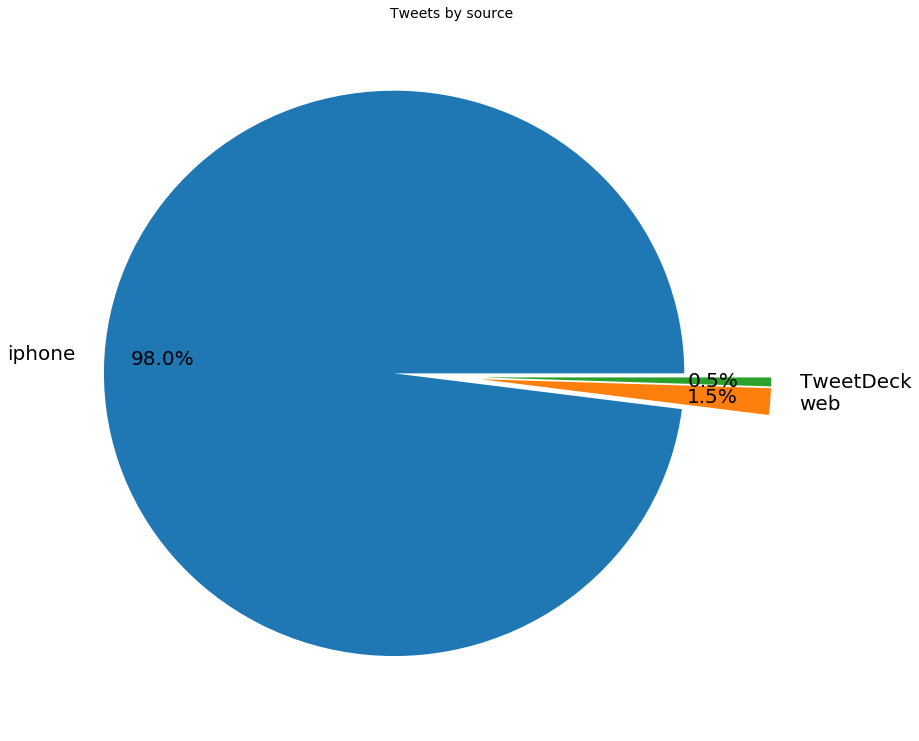

In [4]:
#Set lists to 
source_list=df.source.value_counts().index
value_list=list(df.source.value_counts())

#Using matplotlib
pie, ax = plt.subplots(figsize=[13,13])
labels = source_list
plt.pie(x=value_list, autopct="%.1f%%", explode=[0.2,0.1,0.1], labels=labels, pctdistance=0.8, textprops={'fontsize': 20})
plt.title("Tweets by source", fontsize=14);


98% of users use `iphone` to share WeRateDogs status

#### what is the partition  tweet counts by day of the week ?

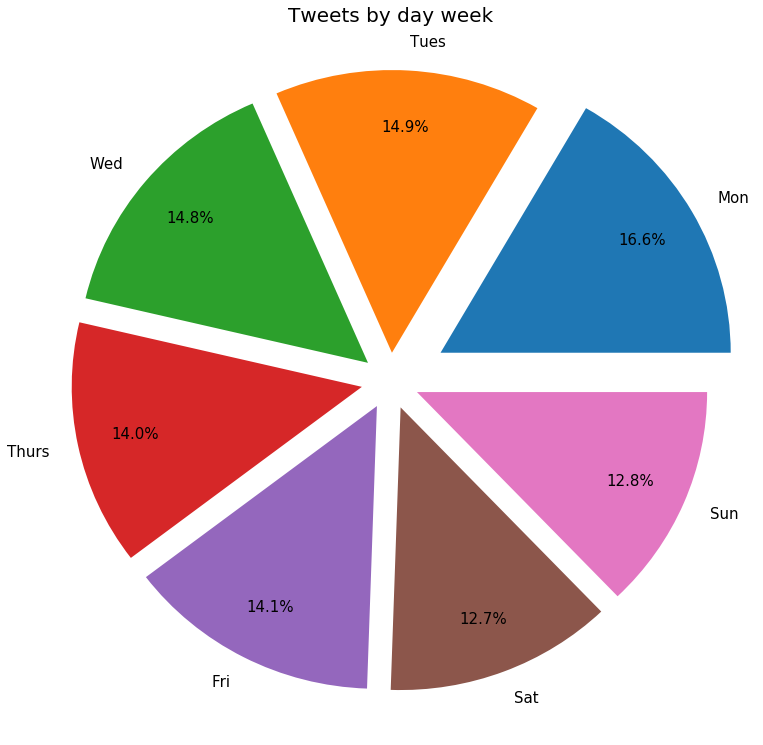

In [5]:
df['timestamp'] = pd.to_datetime(df.timestamp)
day_names = ['Mon', 'Tues', 'Wed', 'Thurs','Fri', 'Sat', 'Sun']
day_num=df.timestamp.dt.dayofweek
day_count=list(day_num.value_counts().sort_index())


#Using matplotlib
pie, ax = plt.subplots(figsize=[13,13])
labels = day_names
plt.pie(x=day_count, autopct="%.1f%%", explode=[0.2,0.1,0.1,0.1,0.1,0.1,0.1], labels=labels, pctdistance=0.8, textprops={'fontsize': 15})
plt.title("Tweets by day week", fontsize=20);


The partition of the number of tweets per day of  week seems balanced, however Monday remains the day that saw more tweets with 16.6%

#### What is the partition of tweets by session time ?

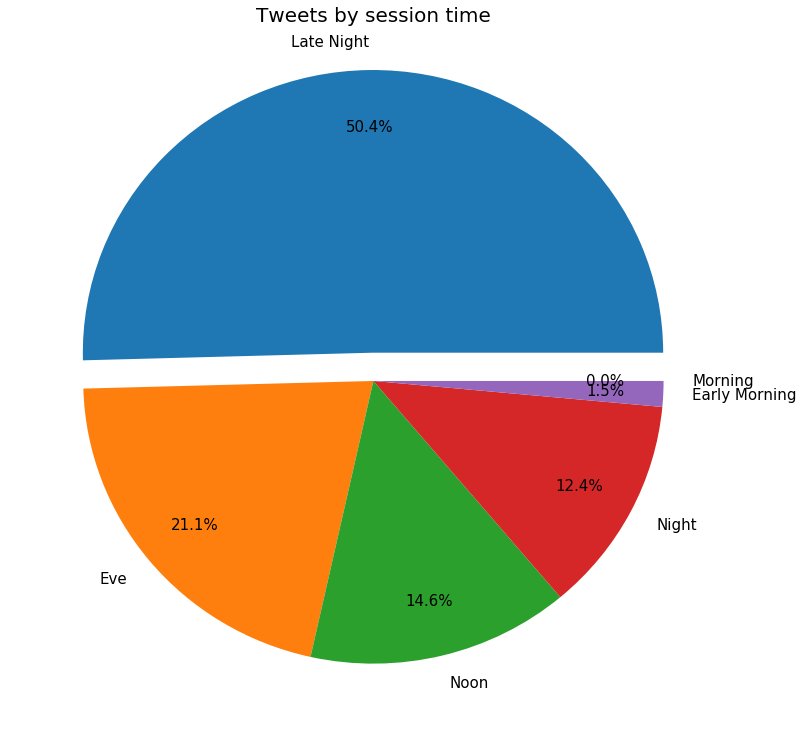

In [54]:
df['hour']=df['timestamp'].dt.hour
hour = [0,4,8,12,16,20,24]
sess = ['Late Night', 'Early Morning','Morning','Noon','Eve','Night']
df['session'] = pd.cut(df['hour'], bins=hour, labels=sess, include_lowest=True)

session_num=df.session
session_count=list(session_num.value_counts())
session_name=list(session_num.value_counts().index)

#Using matplotlib
pie, ax = plt.subplots(figsize=[13,13])
labels = session_name
plt.pie(x=session_count, autopct="%.1f%%",explode=[0.1,0.0,0.0,0.0,0.0,0.0], labels=labels, pctdistance=0.8, textprops={'fontsize': 15})
plt.title("Tweets by session time", fontsize=20);




More thant 50% of all tweets are created in late night On the other hand no tweet was created during the morning !


#### What are the most 10 breeds appeared in WeRateDogs stauts?

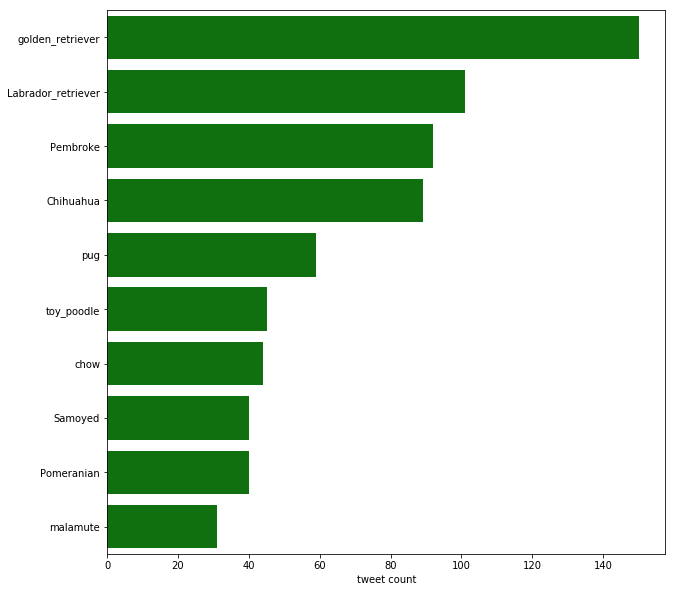

In [101]:

breeds=df.breeds.value_counts()[:10]
list_breeds=list(breeds.index)
list_counts=list(breeds)
ax = plt.subplots(figsize=[10,10])
sns.barplot( list_counts,list_breeds, color='g')
plt.xlabel('tweet count')
plt.show()

The golden retriever is most dog rated in WeRateDogs with over than 150 status

#### What are the top 10 highly rated breeds ?

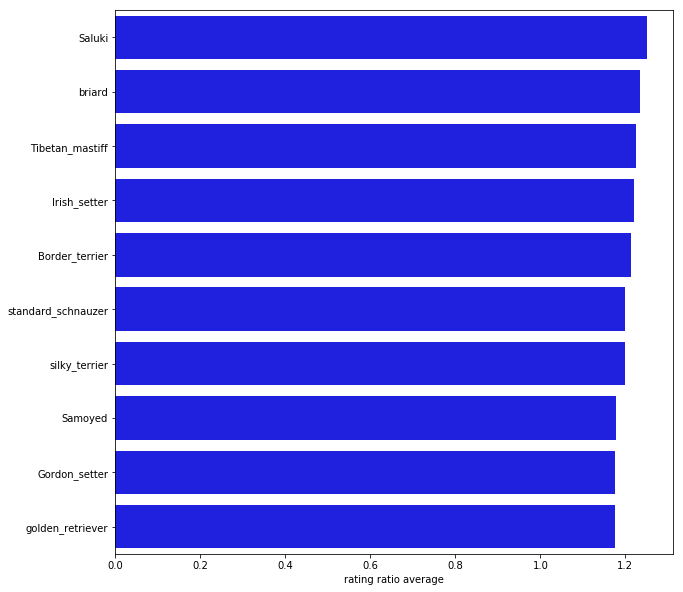

In [102]:

df['ratio']=df.rating_numerator/df.rating_denominator
ratio=df['ratio'].groupby(df['breeds']).mean().sort_values(ascending=False)[:10]
list_breeds=list(ratio.index)
list_ratio=list(ratio)

ax = plt.subplots(figsize=[10,10])
sns.barplot( list_ratio,list_breeds, color='B')
plt.xlabel('rating ratio average')
plt.show()

The best rated breed by tweeter users is `Saluki`

#### What are the worst 10  rated breeds ?

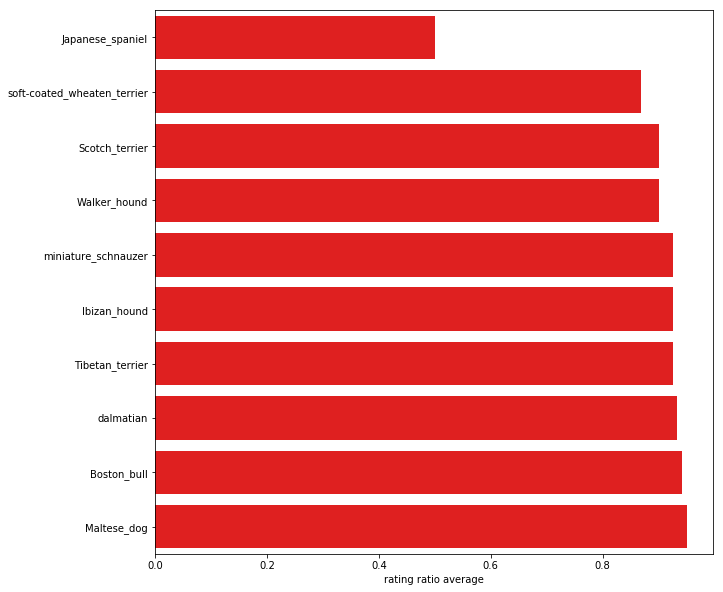

In [103]:

df['ratio']=df.rating_numerator/df.rating_denominator
ratio=df['ratio'].groupby(df['breeds']).mean().sort_values(ascending=True)[:10]
list_breeds=list(ratio.index)
list_ratio=list(ratio)

ax = plt.subplots(figsize=[10,10])
sns.barplot( list_ratio,list_breeds, color='r')
plt.xlabel('rating ratio average')
plt.show()

the worst rated breed by tweeter users is the `japanese_spaniel`

#### what are the top 10 breeds appeared in the most favorited tweets and what is their ratio mean ?

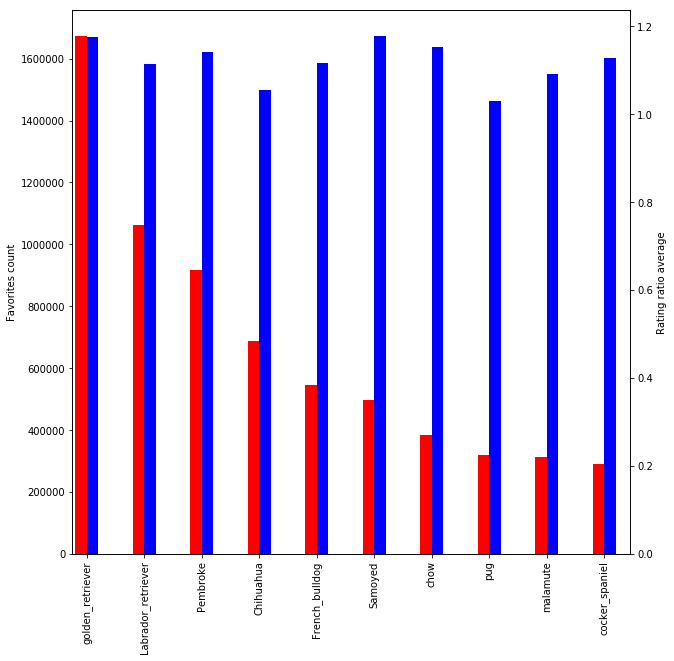

In [104]:
favorite_count=df['favorite_count'].groupby(df['breeds']).sum().sort_values(ascending=False)[:10]
ratio=df['ratio'].groupby(df['breeds']).mean()

column_names = ["breeds","favotite_count", "mean_ratio"]
df_extract = pd.DataFrame(columns = column_names)
data_list=[]
for breed in favorite_count.index:
    data_list=[]
    data_list.append(breed)
    data_list.append(favorite_count[breed])
    data_list.append(ratio[breed])
    df_length = len(df_extract)
    df_extract.loc[df_length] = data_list
    df_extract.append(data_list)       

fig = plt.figure(figsize=(10,10)) # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.2

df_extract.favotite_count.plot(kind='bar', color='red', ax=ax, width=width, position=1)
df_extract.mean_ratio.plot(kind='bar', color='blue', ax=ax2, width=width, position=0)
x_pos = np.arange(len(favorite_count.index))
plt.xticks(x_pos, favorite_count.index)
ax.set_ylabel('Favorites count')
ax2.set_ylabel('Rating ratio average')

plt.show()
    

`The golden retriever` is the most breed appeard in the most favorated tweets with 1.2 in rating ratio on average.